# 비장하게 앞으로 나아가는 듯한, 결의를 다지게 하고, 자아를 말하는 것 같은 곡
## 1. 전처리
*memo: 음악의 7대 구성 요소인 리듬, 가락, 화성, 형식, 셈여림, 빠르기, 음색에 입각하여 각 데이터의 특징을 추출한다.

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment
import librosa.display

## 2. Feature Extraction
해당 카테고리에서 '비장함'이란 특징을 마이닝 해야하는 상황이다. 여기서 '비장함'이란 intro-verse-chorus-...-bridge에 걸쳐 나타나는 뚜렷한 **'기승전결식 전개'**인 것 같았다. 따라서 아래와 같은 특징을 분석하기로 했다.
- Magnitude Scaling
- Rhythmic / Tempo Features
- Timbre Features<br><br>
### 1) Tempo Features(Tempogram) <- Rhythmic Features와 동일
A tempogram is a time-tempo representation that encodes the local tempo of a music signal over time.
문제는 아래 셋 중 어떤 것을 사용하는가의 문제이다.
#### (1) Fourier Tempogram
기본적으로 novelty function의 magnitude spectrogram을 말하는 것이다.<br>여기서 novelty function이란 note, energy, spectral feature 등에서 변화(sudden changes)가 생기는 순간(onset)을 감지하는 함수다.
#### (2) Autocorrelation Tempogram
"자기 상관 분석은 잡음에 의해 가려진 주기적인 신호의 존재 또는 고조파 주파수에 의해 암시된 신호에서 누락된 기본 주파수를 식별하는 것과 같은 반복 패턴을 찾기 위한 수학적 도구다. 시간 영역 신호와 같은 함수 또는 일련의 값을 분석하기 위해 신호 처리에 자주 사용한다." - Wikipedia<br>
라고 나와있는 것으로 미루어 보았을 때 왠지 이거 말고 (1)이 더 맞을 것 같은...
#### (3) Estimating Global Tempo
이게 가장 보편적인 데이터가 될 것 같다.<br>

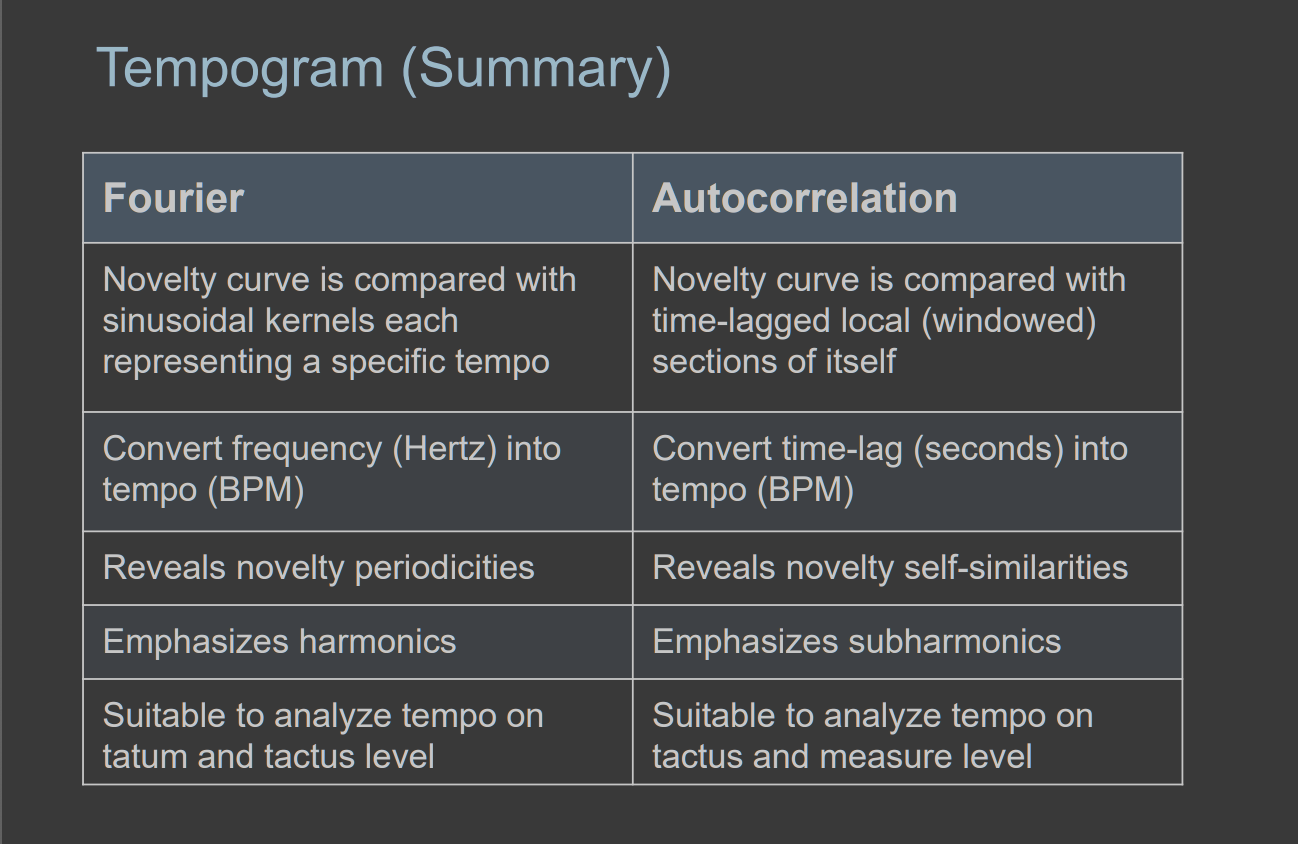

In [6]:
from IPython.display import Image
Image("comparison.png")

In [5]:
"""
sound = AudioSegment.from_mp3("beinggoodisntgoodenough.mp3")
sound.export("beinggoodisntgoodenough.wav", format="wav")
sound = AudioSegment.from_mp3("guerilla.mp3")
sound.export("guerilla.wav", format="wav")
sound = AudioSegment.from_mp3("imthegreateststar.mp3")
sound.export("imthegreaeststar.wav", format="wav")
sound = AudioSegment.from_mp3("letmelive.mp3")
sound.export("letmelive.wav", format="wav")
sound = AudioSegment.from_mp3("nottoday.mp3")
sound.export("nottoday.wav", format="wav")
sound = AudioSegment.from_mp3("run.mp3")
sound.export("run.wav", format="wav")
sound = AudioSegment.from_mp3("theboys.mp3")
sound.export("theboys.wav", format="wav")
sound = AudioSegment.from_mp3("thefinalcountdown.mp3")
sound.export("thefinalcountdown.wav", format="wav")
sound = AudioSegment.from_mp3("thisisme.mp3")
sound.export("thisisme.wav", format="wav")
sound = AudioSegment.from_mp3("guerilla_inst.mp3")
sound.export("guerilla_inst.wav", format="wav")
sound = AudioSegment.from_mp3("nottoday_inst.mp3")
sound.export("nottoday_inst.wav", format="wav")
sound = AudioSegment.from_mp3("theboys_inst.mp3")
sound.export("theboys_inst.wav", format="wav")
sound = AudioSegment.from_mp3("thisisme_inst.mp3")
sound.export("thisisme_inst.wav", format="wav")
sound = AudioSegment.from_mp3("runnin_inst.mp3")
sound.export("runnin_inst.wav", format="wav")
sound = AudioSegment.from_mp3("runnin.mp3")
sound.export("runnin.wav", format="wav")
"""

<_io.BufferedRandom name='runnin.wav'>

**① guerilla.wav**
- **guerilla-intro**
본 카테고리의 곡들에서 '비장함'아라는 특징을 마이닝 해야한다. 여기 속한 곡들의 특징으로 미루어 보았을 때 '비장함'이란 intro-verse-chorus-bridge를 거치며 나타나는 **뚜렷한 기승전결식 전개**인 것 같았다. 따라서 곡의 분수령을 부분별로 정확히 잡고, 아래와 같은 특징들을 분석하기로 했다.
- magnitude scaling
- rhythmic, tempo features
- energy, timbre features<br><br>
### **1) Tempo Estimation(Tempogram)**
#### (1) novelty function

Text(0.5, 1.0, 'Novelty Function')

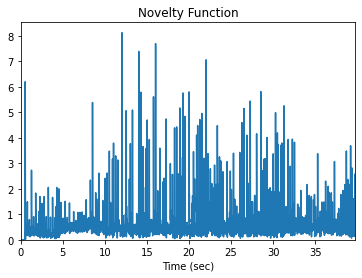

In [43]:
# Compute the onset envelope, i.e. novelty function
guerilla_intro, sr = librosa.load('guerilla.wav', sr=44100, duration=39.787)
onset_env = librosa.onset.onset_strength(guerilla_intro, sr=sr, hop_length=hop_length, n_fft=2048)
# Plot the onset envelope
frames = range(len(onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(t, onset_env)
plt.xlim(0, t.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

그리고 이 novelty function의 STFT를 계산하여 Fourier Tempogram으로 나타낸다.

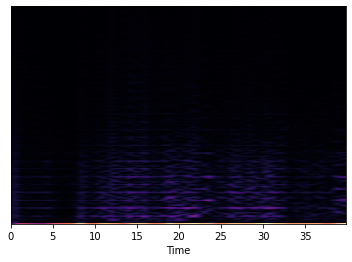

In [14]:
S = librosa.stft(onset_env, hop_length=1, n_fft=512)
fourier_tempogram = np.absolute(S)
librosa.display.specshow(fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

이번엔 Global Tempo(beats per minute)를 분석해본다.

In [15]:
# 인자값 좀 조정하기
tempo = librosa.beat.tempo(guerilla_intro, sr=sr)
print(tempo)

[120.18531977]


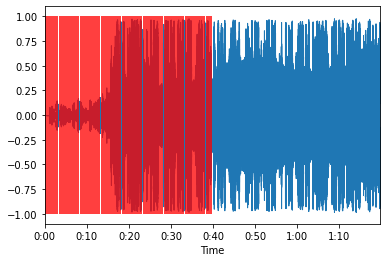

In [16]:
# Visualize the tempo estimate on top of the input signal
T = len(guerilla_intro)/float(sr)
seconds_per_beat = 60.0/tempo[0]
beat_times = np.arange(0, T, seconds_per_beat)
librosa.display.waveplot(guerilla_intro)
plt.vlines(beat_times, -1, 1, color='r')


- **guerilla-verse**

In [18]:
guerilla_verse, sr = librosa.load('guerilla.wav', sr=44100, offset=39.787, duration=15.712)
tempo = librosa.beat.tempo(guerilla_verse, sr=sr)
print(tempo)

[120.18531977]


이 템포 데이터는 곡의 다른 부분이라도 항상 같게 나올 것이다(실제로 해봤는데 다 같게 나온다.)

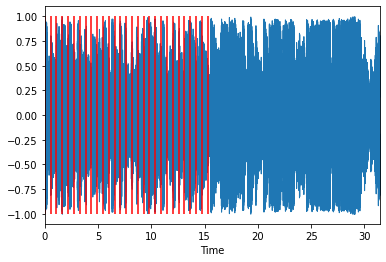

In [44]:
T = len(guerilla_verse)/float(sr)
seconds_per_beat = 60.0/tempo[0]
beat_times = np.arange(0, T, seconds_per_beat)
librosa.display.waveplot(guerilla_verse)
plt.vlines(beat_times, -1, 1, color='r')

- **guerilla-chorus1**<br>
여기서부터 잠시 보류해야겠다... 템포 분석 방법도 엄청 여러가지라서 헷갈린다. 잠시 dymanic tempo의 결과를 보려고 한다.

In [26]:
guerilla_chorus1, sr = librosa.load('guerilla.wav', sr=44100, offset=55.499, duration=14.485)
tempo = librosa.beat.tempo(guerilla_chorus1, sr=sr)
print(tempo)

[120.18531977]


In [25]:
guerilla, sr = librosa.load('guerilla.wav', sr=44100)
onset_env = librosa.onset.onset_strength(guerilla, sr=sr)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
print(dtempo)

[120.18531977 120.18531977 120.18531977 ... 126.04801829 126.04801829
 126.04801829]


아 마지막으로 가니 좀 달라진다. 그럼 그냥 그대로 가야겠다.


In [27]:
guerilla_chorus2, sr = librosa.load('guerilla.wav', sr=44100, offset=69.984, duration=18.475)
tempo = librosa.beat.tempo(guerilla_chorus2, sr=sr)
print(tempo)

[120.18531977]


**② let me live**<br>

In [28]:
lml, sr = librosa.load('letmelive.wav', sr=44100)
onset_env = librosa.onset.onset_strength(bgige, sr=sr)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
print(dtempo)

[ 79.50721154  79.50721154  79.50721154 ... 156.60511364 156.60511364
 156.60511364]


In [29]:
lml_intro, sr = librosa.load('letmelive.wav', sr=44100, duration=25.6)
tempo = librosa.beat.tempo(lml_intro, sr=sr)
print(tempo)

[126.04801829]


In [30]:
lml_verse, sr = librosa.load('letmelive.wav', sr=44100, offset=62.286, duration=24.338)
tempo = librosa.beat.tempo(lml_verse, sr=sr)
print(tempo)

[151.99908088]


In [31]:
lml_chorus, sr = librosa.load('letmelive.wav', sr=44100, offset=140.217, duration=14.407)
tempo = librosa.beat.tempo(lml_chorus, sr=sr)
print(tempo)

[126.04801829]


In [32]:
lml_bridge, sr = librosa.load('letmelive.wav', sr=44100, offset=218.145, duration=18.902)
tempo = librosa.beat.tempo(lml_bridge, sr=sr)
print(tempo)

[147.65625]


③ not today

In [34]:
ntd, sr = librosa.load('nottoday.wav', sr=44100)
onset_env = librosa.onset.onset_strength(bgige, sr=sr)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
print(dtempo)

[ 79.50721154  79.50721154  79.50721154 ... 156.60511364 156.60511364
 156.60511364]


In [35]:
ntd_intro, sr = librosa.load('nottoday.wav', sr=44100, duration=17.474)
tempo = librosa.beat.tempo(ntd_intro, sr=sr)
print(tempo)

[109.95678191]


In [36]:
ntd_verse1, sr = librosa.load('nottoday.wav', sr=44100, offset=17.474, duration=35.118)
tempo = librosa.beat.tempo(ntd_verse1, sr=sr)
print(tempo)

[109.95678191]


In [37]:
ntd_verse2, sr = librosa.load('nottoday.wav', sr=44100, offset=52.592, duration=17.308)
tempo = librosa.beat.tempo(ntd_verse2, sr=sr)
print(tempo)

[109.95678191]


In [38]:
ntd_chorus, sr = librosa.load('nottoday.wav', sr=44100, offset=69.9, duration=34.592)
tempo = librosa.beat.tempo(ntd_chorus, sr=sr)
print(tempo)

[143.5546875]


In [39]:
ntd_chorus, sr = librosa.load('nottoday.wav', sr=44100, offset=174.574, duration=17.86)
tempo = librosa.beat.tempo(ntd_chorus, sr=sr)
print(tempo)

[109.95678191]


## 2) Magnitude Scaling
**① guerilla.wav**

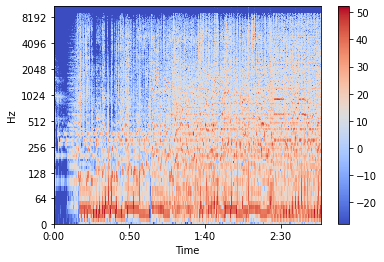

In [41]:
guerilla, sr = librosa.load('guerilla.wav', sr=44100, duration=88.459)
gue_stft = np.abs(librosa.stft(guerilla))
librosa.display.specshow(librosa.amplitude_to_db(gue_stft), x_axis='time', y_axis='log')
plt.colorbar()

**② let me live**

**③ not today**

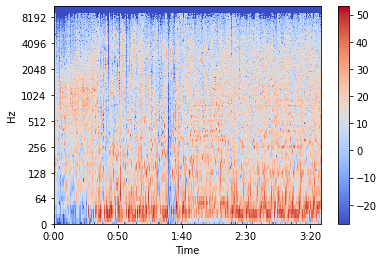

In [42]:
ntd, sr = librosa.load('nottoday.wav', sr=44100, duration=104.492)
ntd_stft = np.abs(librosa.stft(ntd))
librosa.display.specshow(librosa.amplitude_to_db(ntd_stft), x_axis='time', y_axis='log')
plt.colorbar()

In [ ]:
#도입부
bgige1, sr = librosa.load('bgige.wav', sr=44100, offset=10.357, duration=4.294)
librosa.display.waveplot(bgige1, sr)